In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
from tqdm import tqdm
from scipy.stats import kendalltau
import os
import graphscope

In [2]:
graphscope.set_option(show_log=True) # do not run this for stand-alone mode,

## Initiate Graph on Minikube

To setup Graphscope Distributed mode on local computer:
+ Install docker, Minikube and Helm
+ Start Minikube
+ Install Graphscope via Helm
Details: https://graphscope.io/docs/deployment.html

In [3]:
sess=graphscope.session()

2023-05-19 14:12:01,723 [INFO][session:641]: Initializing graphscope session with parameters: {'addr': None, 'mode': 'eager', 'cluster_type': 'k8s', 'num_workers': 2, 'preemptive': True, 'k8s_namespace': None, 'k8s_service_type': 'NodePort', 'k8s_image_registry': 'registry.cn-hongkong.aliyuncs.com', 'k8s_image_repository': 'graphscope', 'k8s_image_tag': '0.21.0', 'k8s_image_pull_policy': 'IfNotPresent', 'k8s_image_pull_secrets': [], 'k8s_coordinator_cpu': 0.5, 'k8s_coordinator_mem': '512Mi', 'etcd_addrs': None, 'etcd_listening_client_port': 2379, 'etcd_listening_peer_port': 2380, 'k8s_vineyard_image': 'vineyardcloudnative/vineyardd:latest', 'k8s_vineyard_deployment': None, 'k8s_vineyard_cpu': 0.5, 'k8s_vineyard_mem': '512Mi', 'vineyard_shared_mem': '4Gi', 'k8s_engine_cpu': 0.2, 'k8s_engine_mem': '1Gi', 'k8s_mars_worker_cpu': 0.2, 'k8s_mars_worker_mem': '4Mi', 'k8s_mars_scheduler_cpu': 0.2, 'k8s_mars_scheduler_mem': '2Mi', 'k8s_coordinator_pod_node_selector': None, 'k8s_engine_pod_node_

In [6]:
#import networkx as nx
import graphscope.nx as nx # To use graphscope for calculating pagerank, only need to do replace "nx"

## Run this section one time only

Download database here:
https://drive.google.com/file/d/1v0-m0ApSyw_ylNYkjz7VOq9MEBFdrisB/view?usp=sharing

In [7]:
%%time
data_path='/home/longta/Octane/Page rank/bttc/data/final/bttc_14m_16-19m.csv'
result_path='/home/longta/Octane/Page rank/bttc/result'
data_df=pd.read_csv(data_path)

<timed exec>:3: DtypeWarning: Columns (7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: user 15.7 s, sys: 2.72 s, total: 18.4 s
Wall time: 20.1 s


In [8]:
data_df.head(20)

,Unnamed: 0,block_number,from_address,to_address,gas_used,gas_price,gas,input,value,token_transfer,token_contract
0,0,14112152,0x09601a02e2451d22de5362b34e7ccda3036d8b59,0x6dbad4bd16c15ae6ddeaa640626e5a3e151f02fc,177466,300000000000000,NaN,NaN,NaN,NaN,NaN
1,1,14112152,0x80d97657d0c9cc2b675af4ed5a927c04efe923be,0x6dbad4bd16c15ae6ddeaa640626e5a3e151f02fc,152955,300000000000000,NaN,NaN,NaN,NaN,NaN
2,2,14112152,0xab402e84e1495f5d6f056d2e1d061b8fecea6ea3,0x6dbad4bd16c15ae6ddeaa640626e5a3e151f02fc,149514,300000000000000,NaN,NaN,NaN,NaN,NaN
3,3,14112152,0x450f85afb99e89e170ba1ea213ac7ca7df71dad7,0x4994aaaa27098f48b0c8736f69c068a964e769df,21000,300000000000000,NaN,NaN,NaN,NaN,NaN
4,4,14112152,0xee6ee64799d4e01e8df3cc50befa565d76e29eca,0x6dbad4bd16c15ae6ddeaa640626e5a3e151f02fc,149514,300000000000000,NaN,NaN,NaN,NaN,NaN
5,5,14112152,0x46d71e0a6b467af2202d0d1ad6ccc770e08e68a5,0x6dbad4bd16c15ae6ddeaa640626e5a3e151f02fc,152912,300000000000000,NaN,NaN,NaN,NaN,NaN
6,6,14112152,0x787cc1e2fdfffad60eb20957e28863231cf7465c,0xec340f8df75528e19c0e409f3c001613b8fe9071,21000,300000000000000,NaN,NaN,NaN,NaN,NaN
7,7,14112152,0x89d03aff4b758a9ac436f3a7737b48dc2e16990c,0x6dbad4bd16c15ae6ddeaa640626e5a3e151f02fc,152628,300000000000000,NaN,NaN,NaN,NaN,NaN
8,8,14112152,0x38a8af0d0b5a18d5652838bcb351430467a29680,0x6dbad4bd16c15ae6ddeaa640626e5a3e151f02fc,173773,300000000000000,NaN,NaN,NaN,NaN,NaN
9,9,14112152,0xcf09de42c63d927e62671a17483106ddb5e5e596,0x6dbad4bd16c15ae6ddeaa640626e5a3e151f02fc,152912,300000000000000,NaN,NaN,NaN,NaN,NaN


In [9]:
%%time
data_df['gas_used']=data_df['gas_used']*data_df['gas_price']

CPU times: user 69.7 ms, sys: 284 ms, total: 354 ms
Wall time: 109 ms


In [10]:
data_df

,Unnamed: 0,block_number,from_address,to_address,gas_used,gas_price,gas,input,value,token_transfer,token_contract
0,0,14112152,0x09601a02e2451d22de5362b34e7ccda3036d8b59,0x6dbad4bd16c15ae6ddeaa640626e5a3e151f02fc,-2100432221128654848,300000000000000,NaN,NaN,NaN,NaN,NaN
1,1,14112152,0x80d97657d0c9cc2b675af4ed5a927c04efe923be,0x6dbad4bd16c15ae6ddeaa640626e5a3e151f02fc,8993011852580896768,300000000000000,NaN,NaN,NaN,NaN,NaN
2,2,14112152,0xab402e84e1495f5d6f056d2e1d061b8fecea6ea3,0x6dbad4bd16c15ae6ddeaa640626e5a3e151f02fc,7960711852580896768,300000000000000,NaN,NaN,NaN,NaN,NaN
3,3,14112152,0x450f85afb99e89e170ba1ea213ac7ca7df71dad7,0x4994aaaa27098f48b0c8736f69c068a964e769df,6300000000000000000,300000000000000,NaN,NaN,NaN,NaN,NaN
4,4,14112152,0xee6ee64799d4e01e8df3cc50befa565d76e29eca,0x6dbad4bd16c15ae6ddeaa640626e5a3e151f02fc,7960711852580896768,300000000000000,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
7943365,6464600,19509376,0xdba3f1c78f391a3b280065bfeb7c6723768b5544,0x80b167b76e91005c1265f7edd658171608e4a2c2,6300000000000000000,300000000000000,25200.0,0x,1099990000000000000000,0,0x
7943366,6464601,19509377,0x2a1391c71d5c0a4444e3dffa3d43353cf72a212b,0x43aaaead3c706deb5410c5bda9b075063e11c4bb,6300000000000000000,300000000000000,25200.0,0x,1099990000000000000000,0,0x
7943367,6464602,19509378,0x75f52766a6a23f736edefcd69dfbe6153a48c3f3,0x960f53196181a6a76ad20eecca5591215c6d0fa4,4815650882580896768,300001000000000,10000000.0,0x8dbdbe6d000000000000000000000000000000000000...,0,8696314321021820000000,0x23181f21dea5936e24163ffaba4ea3b316b57f3c
7943368,6464603,19509378,0x960f53196181a6a76ad20eecca5591215c6d0fa4,0xc09756432dad2ff50b2d40618f7b04546dd20043,4815650882580896768,300001000000000,10000000.0,0x8dbdbe6d000000000000000000000000000000000000...,0,204052092773189385,0xce6b517e90e7c425a172b91ccf706633a09c2dfd


## Calculating weight

In [11]:
def logistic(x,
             a=2,
             b=1 / 64):
    return a / (1.0 + np.exp(-b * x))
def normalize(df):
    normalized_df=(df-df.min())/(df.max()-df.min())
    return normalized_df

In [12]:
%%time
print('initally',len(data_df),'txns')

data_df = data_df[(data_df['from_address']!=data_df['to_address'])]# remove loop
print('after removing loop',len(data_df),'txns')

#data_df = data_df.drop_duplicates(subset=['block_number','from_address','to_address'])# remove duplicate 
data_df = data_df.drop_duplicates(subset=['from_address','to_address'], keep='last')# remove duplicate 

print('for all txns with same address(from and to), only take the lastest one:',len(data_df),'txns')

data_df=data_df.dropna(subset=['from_address'])
print('after remove nan in from_address',len(data_df))

data_df=data_df.dropna(subset=['to_address'])
print('after remove nan in to_address',len(data_df))


initally 7943370 txns
after removing loop 7936032 txns
for all txns with same address(from and to), only take the lastest one: 5342683 txns
after remove nan in from_address 5342683
after remove nan in to_address 5342679
CPU times: user 5.69 s, sys: 637 ms, total: 6.33 s
Wall time: 6.32 s


#### Get block date first

In [13]:
activate_time=90
blockperday_set=28800 # ~ 2 second to generate each block
block_min=data_df['block_number'].min()
block_max=data_df['block_number'].max()
print(block_min,block_max)

14112152 19509379


In [14]:
%%time
data_df['block_date']=((data_df['block_number']-block_min-activate_time)/blockperday_set).astype(int) 
# all block on that day share the same weight
data_df

CPU times: user 115 ms, sys: 225 ms, total: 340 ms
Wall time: 62.9 ms


,Unnamed: 0,block_number,from_address,to_address,gas_used,gas_price,gas,input,value,token_transfer,token_contract,block_date
0,0,14112152,0x09601a02e2451d22de5362b34e7ccda3036d8b59,0x6dbad4bd16c15ae6ddeaa640626e5a3e151f02fc,-2100432221128654848,300000000000000,NaN,NaN,NaN,NaN,NaN,0
3,3,14112152,0x450f85afb99e89e170ba1ea213ac7ca7df71dad7,0x4994aaaa27098f48b0c8736f69c068a964e769df,6300000000000000000,300000000000000,NaN,NaN,NaN,NaN,NaN,0
6,6,14112152,0x787cc1e2fdfffad60eb20957e28863231cf7465c,0xec340f8df75528e19c0e409f3c001613b8fe9071,6300000000000000000,300000000000000,NaN,NaN,NaN,NaN,NaN,0
8,8,14112152,0x38a8af0d0b5a18d5652838bcb351430467a29680,0x6dbad4bd16c15ae6ddeaa640626e5a3e151f02fc,-3208332221128654848,300000000000000,NaN,NaN,NaN,NaN,NaN,0
10,10,14112152,0x6f2970c3ed45f4d3982a9b65296bb78b95c2b944,0x6dbad4bd16c15ae6ddeaa640626e5a3e151f02fc,-8522832221128654848,300000000000000,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...
7943365,6464600,19509376,0xdba3f1c78f391a3b280065bfeb7c6723768b5544,0x80b167b76e91005c1265f7edd658171608e4a2c2,6300000000000000000,300000000000000,25200.0,0x,1099990000000000000000,0,0x,187
7943366,6464601,19509377,0x2a1391c71d5c0a4444e3dffa3d43353cf72a212b,0x43aaaead3c706deb5410c5bda9b075063e11c4bb,6300000000000000000,300000000000000,25200.0,0x,1099990000000000000000,0,0x,187
7943367,6464602,19509378,0x75f52766a6a23f736edefcd69dfbe6153a48c3f3,0x960f53196181a6a76ad20eecca5591215c6d0fa4,4815650882580896768,300001000000000,10000000.0,0x8dbdbe6d000000000000000000000000000000000000...,0,8696314321021820000000,0x23181f21dea5936e24163ffaba4ea3b316b57f3c,187
7943368,6464603,19509378,0x960f53196181a6a76ad20eecca5591215c6d0fa4,0xc09756432dad2ff50b2d40618f7b04546dd20043,4815650882580896768,300001000000000,10000000.0,0x8dbdbe6d000000000000000000000000000000000000...,0,204052092773189385,0xce6b517e90e7c425a172b91ccf706633a09c2dfd,187


#### Get weight from block date

In [15]:
a=1
b=1/64
data_df['age_weight']=a / (1.0 + np.exp(-b * data_df['block_date']))

In [16]:
data_df # check if the value is not error (e.g., -inf)

,Unnamed: 0,block_number,from_address,to_address,gas_used,gas_price,gas,input,value,token_transfer,token_contract,block_date,age_weight
0,0,14112152,0x09601a02e2451d22de5362b34e7ccda3036d8b59,0x6dbad4bd16c15ae6ddeaa640626e5a3e151f02fc,-2100432221128654848,300000000000000,NaN,NaN,NaN,NaN,NaN,0,0.500000
3,3,14112152,0x450f85afb99e89e170ba1ea213ac7ca7df71dad7,0x4994aaaa27098f48b0c8736f69c068a964e769df,6300000000000000000,300000000000000,NaN,NaN,NaN,NaN,NaN,0,0.500000
6,6,14112152,0x787cc1e2fdfffad60eb20957e28863231cf7465c,0xec340f8df75528e19c0e409f3c001613b8fe9071,6300000000000000000,300000000000000,NaN,NaN,NaN,NaN,NaN,0,0.500000
8,8,14112152,0x38a8af0d0b5a18d5652838bcb351430467a29680,0x6dbad4bd16c15ae6ddeaa640626e5a3e151f02fc,-3208332221128654848,300000000000000,NaN,NaN,NaN,NaN,NaN,0,0.500000
10,10,14112152,0x6f2970c3ed45f4d3982a9b65296bb78b95c2b944,0x6dbad4bd16c15ae6ddeaa640626e5a3e151f02fc,-8522832221128654848,300000000000000,NaN,NaN,NaN,NaN,NaN,0,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7943365,6464600,19509376,0xdba3f1c78f391a3b280065bfeb7c6723768b5544,0x80b167b76e91005c1265f7edd658171608e4a2c2,6300000000000000000,300000000000000,25200.0,0x,1099990000000000000000,0,0x,187,0.948917
7943366,6464601,19509377,0x2a1391c71d5c0a4444e3dffa3d43353cf72a212b,0x43aaaead3c706deb5410c5bda9b075063e11c4bb,6300000000000000000,300000000000000,25200.0,0x,1099990000000000000000,0,0x,187,0.948917
7943367,6464602,19509378,0x75f52766a6a23f736edefcd69dfbe6153a48c3f3,0x960f53196181a6a76ad20eecca5591215c6d0fa4,4815650882580896768,300001000000000,10000000.0,0x8dbdbe6d000000000000000000000000000000000000...,0,8696314321021820000000,0x23181f21dea5936e24163ffaba4ea3b316b57f3c,187,0.948917
7943368,6464603,19509378,0x960f53196181a6a76ad20eecca5591215c6d0fa4,0xc09756432dad2ff50b2d40618f7b04546dd20043,4815650882580896768,300001000000000,10000000.0,0x8dbdbe6d000000000000000000000000000000000000...,0,204052092773189385,0xce6b517e90e7c425a172b91ccf706633a09c2dfd,187,0.948917


In [17]:
def plot_line(col_name,color):
    df=data_df[col_name]
    y_list=df.values.tolist()
    y_list.sort()
    plt.xlabel('block number')
    plt.ylabel('weight')
    plt.plot(data_df['block_number'],y_list,label=col_name,c=color)

Check weight

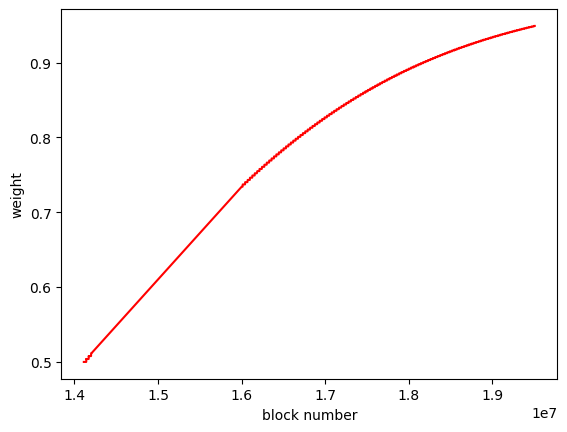

In [18]:
plot_line('age_weight','red')

### Intitalize the graph in distributed mode (check log)

In [19]:
%%time
G = nx.DiGraph()

2023-05-19 14:14:40,670 [INFO][session:1456]: Creating default session ...
2023-05-19 14:14:40,671 [INFO][session:641]: Initializing graphscope session with parameters: {'addr': None, 'mode': 'eager', 'cluster_type': 'hosts', 'num_workers': 1, 'preemptive': True, 'k8s_namespace': None, 'k8s_service_type': 'NodePort', 'k8s_image_registry': 'registry.cn-hongkong.aliyuncs.com', 'k8s_image_repository': 'graphscope', 'k8s_image_tag': '0.21.0', 'k8s_image_pull_policy': 'IfNotPresent', 'k8s_image_pull_secrets': [], 'k8s_coordinator_cpu': 0.5, 'k8s_coordinator_mem': '512Mi', 'etcd_addrs': None, 'etcd_listening_client_port': 2379, 'etcd_listening_peer_port': 2380, 'k8s_vineyard_image': 'vineyardcloudnative/vineyardd:latest', 'k8s_vineyard_deployment': None, 'k8s_vineyard_cpu': 0.5, 'k8s_vineyard_mem': '512Mi', 'vineyard_shared_mem': '4Gi', 'k8s_engine_cpu': 0.2, 'k8s_engine_mem': '1Gi', 'k8s_mars_worker_cpu': 0.2, 'k8s_mars_worker_mem': '4Mi', 'k8s_mars_scheduler_cpu': 0.2, 'k8s_mars_scheduler_

In [20]:
%%time
G=nx.from_pandas_edgelist(data_df, 'from_address', 'to_address', create_using=nx.DiGraph, edge_attr='age_weight')

I20230519 14:14:45.040161 55182 /work/analytical_engine/core/grape_instance.cc:105] Loading graph, graph name: graph_yDsbzayy, graph type: DynamicFragment, directed: 1
CPU times: user 17.7 s, sys: 712 ms, total: 18.4 s
Wall time: 18.4 s


In [21]:
%%time
print('total',G.number_of_nodes(),'nodes and',G.number_of_edges())

I20230519 14:15:04.474368 55182 /work/analytical_engine/core/grape_instance.cc:201] Unloading Graph graph_a37JncCH
I20230519 14:15:23.003353 55182 /opt/graphscope/include/grape/communication/sync_comm.h:210] bcast large buffer in 2 iterations
total 2756187 nodes and 5342679
CPU times: user 3.38 s, sys: 3.74 s, total: 7.12 s
Wall time: 13min 37s


### Personalize weight

In [22]:
# data processing df_data_remove_loop
# extract features
to_weights_df = data_df[['to_address', 'age_weight']]

# group receiver
node_age_weights = to_weights_df.groupby('to_address').sum()

# sum calculation
# sum of weights
s_weights = float(node_age_weights["age_weight"].sum())

# personalized dict
personalized_weights = {k: v/s_weights for k, v in node_age_weights["age_weight"].items()}

In [23]:
for index,item in enumerate(personalized_weights):
    print(item)
    print(personalized_weights[item])
    if index>5: break

0x0000000000000000000000000000000000000000
0.00010737227672544814
0x0000000000000000000000000000000000000001
1.8086123573974274e-05
0x0000000000000000000000000000000000001010
0.008581715553567456
0x0000169dd58f74d367bacdc09892a89a3d4fc218
2.2608330231099769e-07
0x000018dec0937af5a5d0cb8d288cb955efff9dfa
1.9059409967963137e-07
0x00001c04ae5e36971a49fd257eaf8391856925ec
2.313043363058349e-07
0x00001c265f3cfbe380fd77e9a3914d6c403cf97a
2.1900228001227414e-07


### Page Rank calculation

In [24]:
%%time
pr = nx.pagerank(G,
                 alpha=0.5,
                 personalization=personalized_weights,
                 #personalization=in_degree_dict,
                 weight='age_weight')

CPU times: user 27.8 s, sys: 1.05 s, total: 28.9 s
Wall time: 36.4 s


Sort the result

In [25]:
# dict to panda for ranking
pr_col_name='Reputaiton score (x10e6)'
pr_col_name_log='Reputation (Log Scaled)'
pr_df=pd.DataFrame(pr.items(),columns=['Address',pr_col_name])
pr_df[pr_col_name]=pr_df[pr_col_name]*1000000
# Get in and out degree before sorting
pr_df=pr_df.sort_values(pr_col_name,ascending=False)
pr_df=pr_df.reset_index()
# scale the result



pr_df['Ranking']=pr_df.index+1

pr_df.iloc[0:30]

/home/longta/anaconda3/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,index,Address,Reputaiton score (x10e6),Reputation (Log Scaled),In Degree,Out Degree,Degree,Ranking
0,1,0x6dbad4bd16c15ae6ddeaa640626e5a3e151f02fc,219115.778915,12297.355540,1042400,0,1042400,1
1,603382,0xd9eae009f7dd51e95ce93cf60dc5f78697c83f18,35006.454379,10463.287734,113904,148003,261907,2
2,1029151,0xca348681f9b937f06784a2056775a56ca4ab7c1c,29404.568874,10288.905345,108772,1,108773,3
3,1106879,0x556ea264f970c89dfc3c6c05dd645205e9cda57f,27515.804035,10222.515811,96591,137,96728,4
4,1106943,0x5a55592a8e7037069568cb13d91f939e220efcf1,17041.141667,9743.385797,60158,35,60193,5
5,1106582,0xa926d771ec1b132525ac400f64a5d7d74ae20a68,9439.013127,9152.606712,33889,3,33892,6
6,895691,0x0000000000000000000000000000000000001010,8971.294362,9101.785244,41243,0,41243,7
7,443226,0x693eefec7a5cd1ffc5c4ad2260d8194590ba5f4d,7173.085648,8878.091196,25235,60,25295,8
8,1765410,0x7d1f691422b2d31203845af718dfc46c0b1aa5e7,6768.356254,8820.013538,20755,5,20760,9
9,1106577,0x662c065e867354c27150c2c319c4f8a47b82ae6d,5972.929365,8694.992767,20028,4,20032,10


In [26]:
pr_df.to_csv('result/pagerank_result.csv',index=None)

#### Compare w result by a Dung

result by a Dung download here: https://www.notion.so/2209kt/BTTC-f6336d4fb6464999bf2c1a65c89614fe?pvs=4

In [27]:
%%time
result_adung_df=pd.read_csv('/home/longta/Octane/Page rank/bttc/result_adung/export_ranking_bttc_full_April_2023.csv')
merged_df = pd.merge(result_adung_df, pr_df, on='Address')
merged_df_nz=merged_df[merged_df['Reputation (x10e6)']!=0] # only compare non-zero reputation score
merged_df_nz[0:39]

CPU times: user 4.19 s, sys: 1.69 s, total: 5.87 s
Wall time: 18 s


,Address,Reputation (x10e6),Total Transfer,Total Receive,Total Transactions,Total Gas Spent,Degree_x,In Degree_x,Out Degree_x,Ranking Number,index,Reputaiton score (x10e6),Reputation (Log Scaled),In Degree_y,Out Degree_y,Degree_y,Ranking
0,0x6dbad4bd16c15ae6ddeaa640626e5a3e151f02fc,214852.274319,0,1341017,1341017,0.000000,1042400,1042400,0,1,1,219115.778915,12297.355540,1042400,0,1042400,1
1,0xd9eae009f7dd51e95ce93cf60dc5f78697c83f18,34624.861473,148004,119679,267683,932496.873349,261907,113904,148003,2,603382,35006.454379,10463.287734,113904,148003,261907,2
2,0xca348681f9b937f06784a2056775a56ca4ab7c1c,29306.322307,45,159132,159177,283.500000,108773,108772,1,3,1029151,29404.568874,10288.905345,108772,1,108773,3
3,0x556ea264f970c89dfc3c6c05dd645205e9cda57f,27947.490212,242,137125,137367,1596.735421,96728,96591,137,4,1106879,27515.804035,10222.515811,96591,137,96728,4
4,0x5a55592a8e7037069568cb13d91f939e220efcf1,17224.546600,49,172139,172188,385.158252,60193,60158,35,5,1106943,17041.141667,9743.385797,60158,35,60193,5
5,0xa926d771ec1b132525ac400f64a5d7d74ae20a68,9568.351227,55,50439,50494,941.149305,33892,33889,3,6,1106582,9439.013127,9152.606712,33889,3,33892,6
6,0x0000000000000000000000000000000000001010,9068.691751,0,60217,60217,0.000000,41243,41243,0,7,895691,8971.294362,9101.785244,41243,0,41243,7
7,0x693eefec7a5cd1ffc5c4ad2260d8194590ba5f4d,7261.783270,114,34625,34739,873.364494,25295,25235,60,8,443226,7173.085648,8878.091196,25235,60,25295,8
8,0x7d1f691422b2d31203845af718dfc46c0b1aa5e7,6916.754225,44,24988,25032,1069.348986,20760,20755,5,9,1765410,6768.356254,8820.013538,20755,5,20760,9
9,0x662c065e867354c27150c2c319c4f8a47b82ae6d,6032.090624,53,28036,28089,780.944205,20032,20028,4,10,1106577,5972.929365,8694.992767,20028,4,20032,10


#### KTC for comparision w result by a Dung

In [28]:
def ktc_calculation(top_num,df):
    top_name='All'
    if top_num!=0:
        df=df.iloc[0:top_num]
        top_name='top '+str(top_num)
    corr, pval = kendalltau(df['Ranking Number'], df['Ranking'])
    print(f"KTC of ",top_name,corr)

In [29]:
ktc_calculation(100,merged_df)
ktc_calculation(1000,merged_df)
ktc_calculation(10000,merged_df)
ktc_calculation(100000,merged_df)
ktc_calculation(False,merged_df_nz)

KTC of  top 100 0.9898989898989901
KTC of  top 1000 0.9886486486486487
KTC of  top 10000 0.9218661866186617
KTC of  top 100000 0.9593414422144223
KTC of  All 0.9861698675637395


if all calculated KTC > 0.9 : alogrithmn works well!